In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 读取数据（假设已加载为 df，行为 Contig，列为样本）
data = pd.read_csv("../examples/merged_counts.tsv", sep="\t", index_col="Contig")

# 过滤低丰度物种（按出现频率）
filtered_data = data[(data > 500).sum(axis=1) >= 0.2 * data.shape[1]]

# 移除总reads数为零的样本（避免除以零错误）
# filtered_data = filtered_data.loc[:, filtered_data.sum() > 100]

# 计算所有样本的总reads数，并确定最小抽平深度
sample_sums = filtered_data.sum(axis=0)
min_depth = int(sample_sums.min())

# 定义抽平函数
def rarefy_column(col, depth):
    """对单个样本列进行抽平"""
    total = col.sum()
    if total == depth:
        return col
    else:
        # 生成多项式分布抽样结果
        rarefied = np.random.multinomial(depth, col / total)
        return pd.Series(rarefied, index=col.index)

# 设置随机种子保证可重复性
np.random.seed(42)

# 对每个样本进行抽平
rarefied_data = filtered_data.apply(
    rarefy_column,
    axis=0,
    args=(min_depth,)
)

# 将结果转换为DataFrame（保持格式一致）
rarefied_data = pd.DataFrame(
    rarefied_data,
    index=filtered_data.index,
    columns=filtered_data.columns
)

# 输出抽平后的数据
print(f"抽平深度: {min_depth}")

抽平深度: 9709600


In [ ]:
# 计算 Spearman 相关性矩阵
corr_matrix = rarefied_data.T.corr(method='spearman')

# 生成网络边（仅保留显著相关性）
edges = []
threshold = 0.6  # 相关性阈值
p_threshold = 0.05

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr, pval = spearmanr(rarefied_data.iloc[i], rarefied_data.iloc[j])
        if abs(corr) > threshold and pval < p_threshold:
            edges.append((corr_matrix.columns[i], corr_matrix.columns[j], {'weight': corr}))

# 构建网络
G = nx.Graph()
G.add_edges_from(edges)

# 可视化
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=50, width=0.5, edge_color='gray')
plt.title("Co-occurrence Network of Viral Contigs")
plt.show()

# 分析网络属性
print("节点数:", G.number_of_nodes())
print("边数:", G.number_of_edges())
print("平均聚类系数:", nx.average_clustering(G))

核心病毒数量: 823
核心病毒列表: ['vOUT1', 'vOUT10', 'vOUT1010', 'vOUT1013', 'vOUT1014', 'vOUT1016', 'vOUT1020', 'vOUT1023', 'vOUT1024', 'vOUT1029', 'vOUT1030', 'vOUT1034', 'vOUT1037', 'vOUT105', 'vOUT1054', 'vOUT1055', 'vOUT1064', 'vOUT1069', 'vOUT1070', 'vOUT1075', 'vOUT1080', 'vOUT1081', 'vOUT1085', 'vOUT1086', 'vOUT1087', 'vOUT1090', 'vOUT1094', 'vOUT1099', 'vOUT11', 'vOUT1101', 'vOUT1102', 'vOUT1131', 'vOUT1147', 'vOUT1148', 'vOUT1151', 'vOUT1152', 'vOUT1154', 'vOUT1156', 'vOUT1157', 'vOUT1158', 'vOUT1161', 'vOUT1162', 'vOUT1164', 'vOUT1165', 'vOUT1166', 'vOUT1171', 'vOUT1172', 'vOUT1173', 'vOUT1176', 'vOUT1178', 'vOUT1179', 'vOUT119', 'vOUT120', 'vOUT1212', 'vOUT1214', 'vOUT1215', 'vOUT1216', 'vOUT1220', 'vOUT1227', 'vOUT1232', 'vOUT1233', 'vOUT1234', 'vOUT1235', 'vOUT1236', 'vOUT1238', 'vOUT1239', 'vOUT1240', 'vOUT1244', 'vOUT1264', 'vOUT127', 'vOUT1272', 'vOUT1274', 'vOUT128', 'vOUT1280', 'vOUT1283', 'vOUT1285', 'vOUT1288', 'vOUT1289', 'vOUT129', 'vOUT1293', 'vOUT1294', 'vOUT130', 'vOUT1300

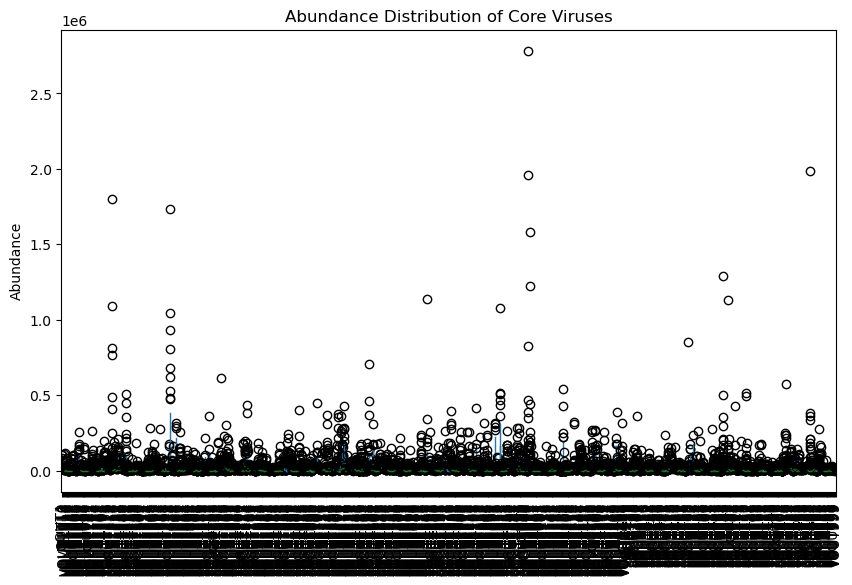

In [9]:
# 计算每个 Contig 的出现频率
presence = (rarefied_data > 0).astype(int)
frequency = presence.mean(axis=1) * 100  # 转换为百分比

# 定义核心病毒（如出现于 >80% 样本）
core_viruses = frequency[frequency > 95].index.tolist()

print(f"核心病毒数量: {len(core_viruses)}")
print("核心病毒列表:", core_viruses)

# 可视化核心病毒丰度分布
core_df = rarefied_data.loc[core_viruses]
core_df.T.plot(kind='box', figsize=(10, 6))
plt.ylabel("Abundance")
plt.title("Abundance Distribution of Core Viruses")
plt.xticks(rotation=90)
plt.show()

In [10]:
core_df

,TXAS01,TXAS02,TXAS06,TXAS09,TXAS10,TXAS11,TXAS12,TXAS14,TXAS15,TXAS18,...,TXHC25,TXHC26,TXHC27,TXHC28,TXHC29,TXHC30,TXHC31,TXHC32,TXHC33,TXHC35
Contig,,,,,,,,,,,,,,,,,,,,,
vOUT1,83088,2209,13999,69267,7643,9574,104585,2104,3,1136,...,104330,0,1588,680,19997,33893,29,2777,26447,321
vOUT10,3181,2702,34,1938,900,1075,703,1995,581,3901,...,3345,2899,476,7530,7546,6543,889,551,2863,1530
vOUT1010,153,283,56,901,148,176,273,133,159,995,...,834,753,216,2723,1166,594,1532,1007,1657,387
vOUT1013,749,948,619,5673,449,330,504,505,753,2307,...,199,2991,381,687,1702,1882,11090,4217,1040,1115
vOUT1014,499,2965,3785,417,1545,314,19494,317,521,648,...,67501,15541,157,1709,4529,1063,7671,21897,2587,886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vOUT978,6,6,24,96,393,1443,6065,610,13,2370,...,61,1392,720,2977,19332,22476,11883,58,37,51
vOUT99,237,411,2402,499,400,778,21,294,0,1658,...,938,37,37,727,574,1008,500,37,960,328
vOUT990,79,174,38,62,141,3513,56,118,46,307,...,159,119,15,632,260,368,2405,689,640,419


## 宿主网络分析

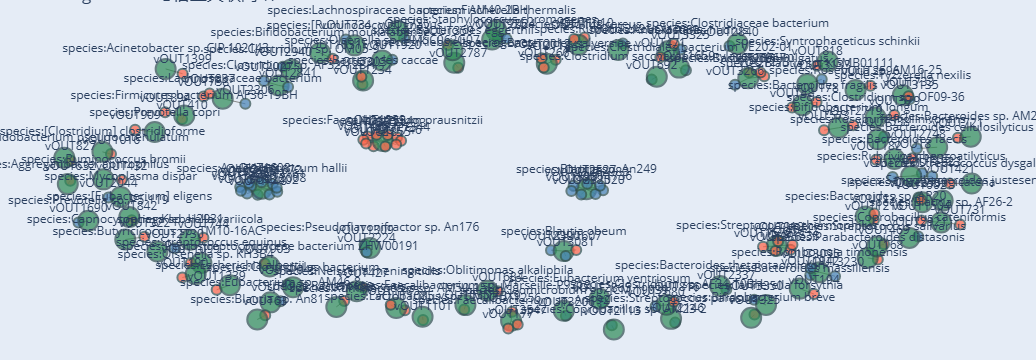

In [2]:
import pandas as pd
import plotly.graph_objects as go

# 读取数据（假设数据已保存为phahost.csv）
df = pd.read_csv('phahost.csv')

# 过滤无效Host（假设Host为"-"或空字符串时无效）
df = df[df['Host'] != '-']
df = df[df['Host'].notna()]

# 创建节点和边
nodes = []
edges = []
host_nodes = set()  # 用于记录已添加的Host节点

# 颜色映射
color_map = {'up': '#FF6347', 'down': '#4682B4'}  # up红色，down蓝色

# 添加节点和边
for idx, row in df.iterrows():
    vout = row['vOUTs']
    host = row['Host']
    group = row['group']
    
    # 添加vOUT节点
    nodes.append({
        'id': vout,
        'label': vout,
        'color': color_map.get(group, 'gray'),  # 默认灰色
        'size': 10  # 节点大小
    })
    
    # 添加Host节点（如果尚未添加）
    if host not in host_nodes:
        nodes.append({
            'id': host,
            'label': host,
            'color': '#2E8B57',  # Host节点统一为绿色
            'size': 20  # Host节点更大
        })
        host_nodes.add(host)
    
    # 添加边（vOUT -> Host）
    edges.append({
        'from': vout,
        'to': host
    })

# 转换为Plotly需要的格式
node_x = []
node_y = []
node_labels = []
node_colors = []
node_sizes = []

# 生成节点布局（简单力导向布局模拟）
# 此处简化布局，实际可能需要复杂算法
import networkx as nx

G = nx.Graph()
for node in nodes:
    G.add_node(node['id'])
for edge in edges:
    G.add_edge(edge['from'], edge['to'])

# 使用networkx的布局算法生成坐标
pos = nx.spring_layout(G, seed=42)

# 提取坐标
for node in nodes:
    x, y = pos[node['id']]
    node_x.append(x)
    node_y.append(y)
    node_labels.append(node['label'])
    node_colors.append(node['color'])
    node_sizes.append(node['size'])

# 绘制网络图
fig = go.Figure()

# 添加边
for edge in edges:
    x0, y0 = pos[edge['from']]
    x1, y1 = pos[edge['to']]
    fig.add_trace(go.Scatter(
        x=[x0, x1, None], 
        y=[y0, y1, None],
        mode='lines',
        line=dict(color='#888', width=1),
        hoverinfo='none'
    ))

# 添加节点
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    marker=dict(
        color=node_colors,
        size=node_sizes,
        line=dict(width=2, color='DarkSlateGrey')
    ),
    text=node_labels,
    textposition="top center",
    hoverinfo='text'
))

# 调整布局
fig.update_layout(
    title='Phage vOUTs与宿主关联网络',
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=30),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()

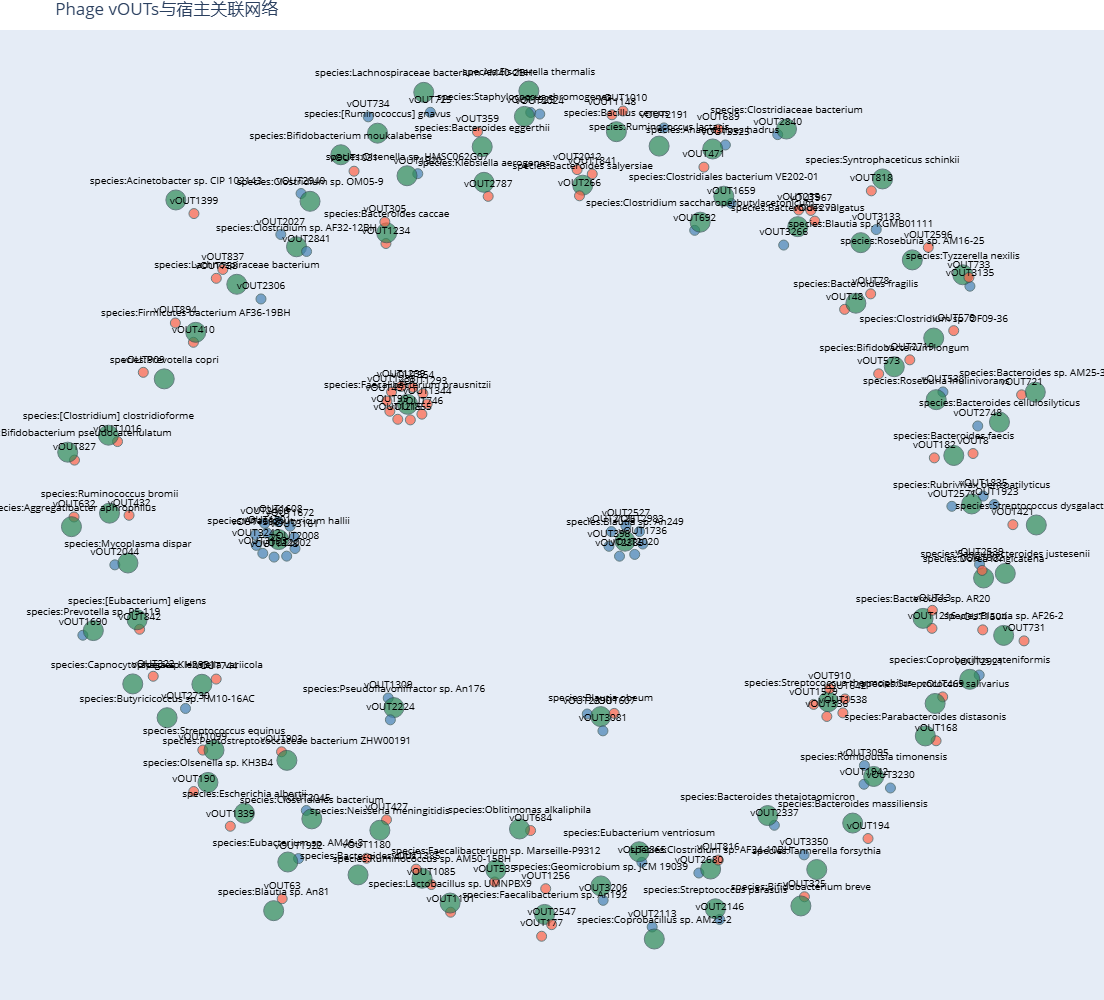

In [7]:
# 调整后的布局参数（关键修改）
pos = nx.spring_layout(G, k=0.5, iterations=200, seed=42)  # 增大节点间距

# 调整后的节点参数
nodes.append({
    'id': vout,
    'label': vout,
    'color': color_map.get(group, 'gray'),
    'size': 8  # 缩小vOUT节点尺寸
})

nodes.append({
    'id': host,
    'label': host,
    'color': '#2E8B57',
    'size': 15  # 缩小Host节点尺寸
})

# 调整后的绘图参数
fig = go.Figure(
    layout=go.Layout(
        width=1080,   # 增大画布宽度
        height=1000,  # 增大画布高度
        title='Phage vOUTs与宿主关联网络',
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=30),
        xaxis=dict(visible=False),
        yaxis=dict(visible=False)
    )
)

# 添加节点时的文本设置
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    marker=dict(
        color=node_colors,
        size=node_sizes,
        line=dict(width=1, color='DarkSlateGrey')  # 缩小边框宽度
    ),
    text=node_labels,
    textposition="top center",
    textfont=dict(size=10, color='black'),  # 调整文本大小和颜色
    hoverinfo='text'
    
))

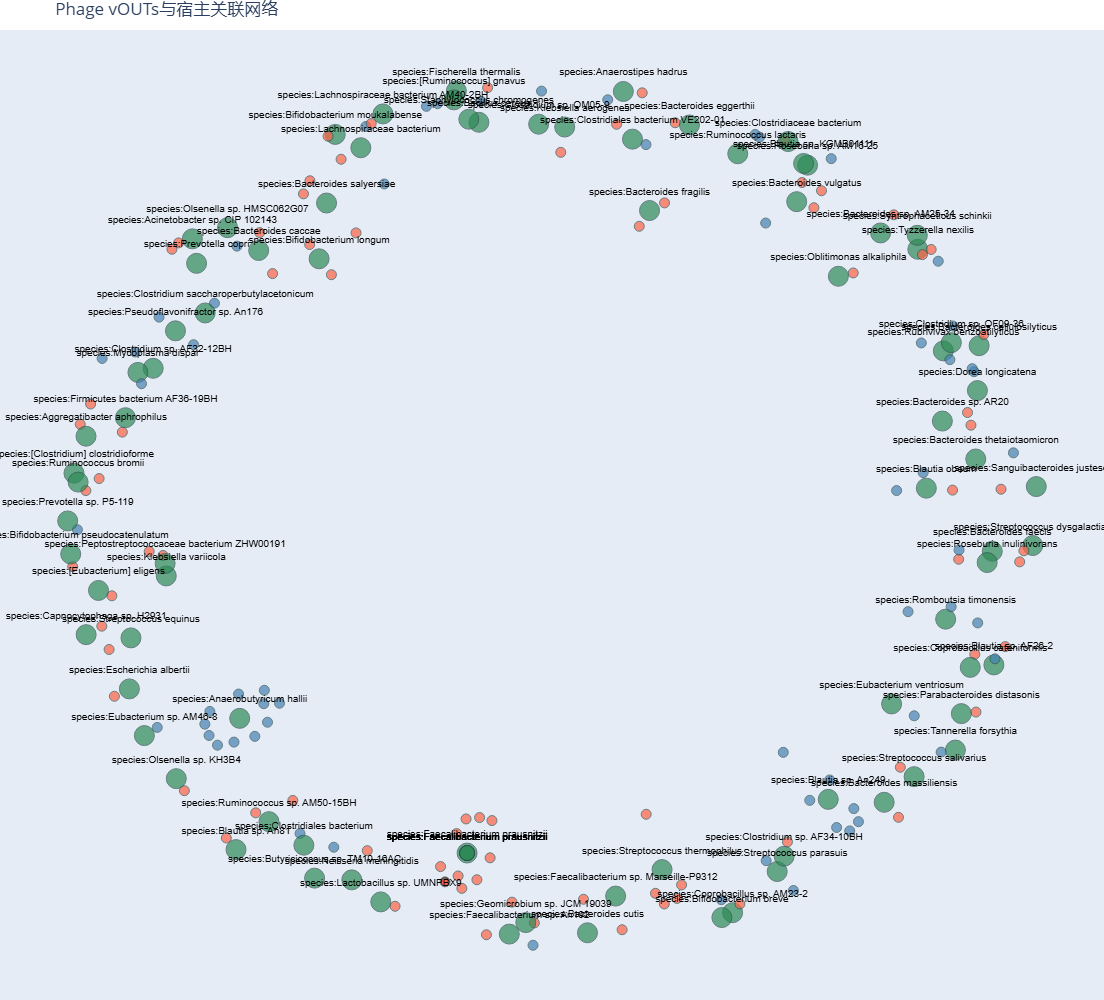

In [11]:
# ... 前面的数据读取和过滤代码保持不变 ...

# 生成节点标签时判断是否为Host节点
node_x = []
node_y = []
node_labels = []  # 修改：只存储需要显示的标签
node_colors = []
node_sizes = []

# 生成节点布局（调整布局参数优化显示）
pos = nx.spring_layout(G, k=0.5, iterations=300, seed=42)  # 增大节点间距

for node in nodes:
    x, y = pos[node['id']]
    node_x.append(x)
    node_y.append(y)
    
    # 关键修改：仅当节点是Host时显示标签
    if node['id'] in host_nodes:
        node_labels.append(node['label'])  # 显示Host名称
    else:
        node_labels.append('')  # vOUT节点设为空字符串
    
    node_colors.append(node['color'])
    node_sizes.append(node['size'])

# 绘制网络图（保持之前的布局优化）
fig = go.Figure(
    layout=go.Layout(
        width=1080,
        height=1000,
        title='Phage vOUTs与宿主关联网络',
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=30),
        xaxis=dict(visible=False),
        yaxis=dict(visible=False)
    )
)

# 添加边（保持不变）...

# 修改后的节点显示设置
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',  # 保留文本模式
    marker=dict(
        color=node_colors,
        size=node_sizes,
        line=dict(width=1, color='DarkSlateGrey')
    ),
    text=node_labels,  # 这里现在只包含Host的标签
    textposition="top center",
    textfont=dict(
        size=10,         # 调大Host标签字号
        color='black',
        family='Arial'
    ),
    hoverinfo='text'     # 悬停时仍显示所有节点信息
))